In [1]:
import os
import sqlite3
import datetime
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Read long term data from APSIM
con = sqlite3.connect(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\0. Long Term\Sorghum_long_term.db')
Harvest = pd.read_sql("Select * from HarvestReport",con)

#Read the Simulations table that has SimulationID matched to Simulation Name
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
#Add SimulationName column
Harvest.loc[:,'SimulationName'] = [Simulations.loc[Harvest.loc[x,'SimulationID'],'Name'] for x in Harvest.index]
Harvest.set_index('SimulationID',inplace=True)
Harvest.drop_duplicates(inplace=True)
#Drop some columns
df=Harvest.drop(['CheckpointID','Zone','AGBiomass', 'AGBiomassOM','FloweringDAS', 'MaturityDAS','Stage'],axis=1)
#Make some new columns
df['climate'] = df['SimulationName'].str[:6]
df['soil'] = df['SimulationName'].str[7:11]
df['cultivar'] = df['SimulationName'].str[12:15]
df['site'] = df['SimulationName'].str[16:18]
df['env'] = df['climate']+"_"+ df['soil']
df['rain_ETo'] = df['rain']/df['potentialET']

df=df.reset_index()

df_bow=df.loc[df['cultivar'] == 'bow']
df_459100_SGb7 = df.loc[df['env'] == '459100_SGb7']

In [3]:
#df.to_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\data\dataframe.csv', index=None, mode='a')

In [3]:
df.env.unique()

array(['460100_LLo0', 'Terang_BrCh', '458099_LTi3', '430085_LTi1',
       '380074_Che8', '459100_SGb7', '431086_Gui0', '431086_Sal0',
       '459100_LLo0', '460100_Che8', 'Elliot_Elli', '429085_LTi1',
       '459100_Gui0'], dtype=object)

In [4]:
df.site.unique()

array(['BJ', 'Te', 'LM', 'Az', 'Lp', 'El'], dtype=object)

In [5]:
#Calculate statistics
grouped = df.groupby("env")
sorted_mean = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).mean().round(1)
sorted_sd = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).std().round(1)
cv = (sorted_sd/sorted_mean*100).round(1)

In [6]:
sorted_mean

380074_Che8     9.1
429085_LTi1     8.4
430085_LTi1     9.9
431086_Gui0     8.0
431086_Sal0    11.1
458099_LTi3     8.4
459100_Gui0     7.5
459100_LLo0    10.2
459100_SGb7     5.2
460100_Che8     8.2
460100_LLo0     9.1
Elliot_Elli     3.6
Terang_BrCh     2.3
dtype: float64

No handles with labels found to put in legend.


Text(-0.47, 17.5, 'CV')

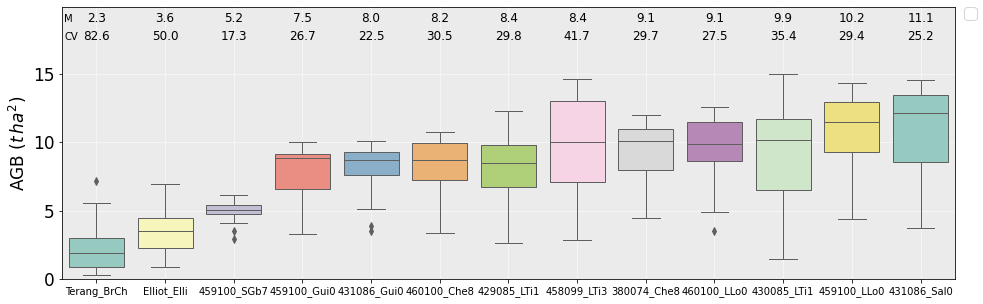

In [7]:
#Order cv accordingly with mean ascending order
reorderlist = ['Terang_BrCh', 'Elliot_Elli','459100_SGb7','459100_Gui0','431086_Gui0','460100_Che8','429085_LTi1',
               '458099_LTi3','460100_LLo0','380074_Che8','430085_LTi1','459100_LLo0','431086_Sal0']
sorted_cv=cv.reindex(reorderlist)

fig= plt.figure(figsize=(16,5))

# Apply order accordingly with mean yield
grouped = df.groupby("env")
sorted_mean = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).mean().sort_values(ascending=True)
#Graph
ax=sns.boxplot(x="env", y="AGB", data=df_bow, palette="Set3", linewidth=1, order=sorted_mean.index)
    
# Formatting graph and background
plt.legend(prop=dict(size=16),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('AGB ($t\,ha^{2}$)', fontsize =17)
plt.xlabel('', fontsize =17)

ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=17)
ax.set_ylim([0,19.9])
#plt.savefig('mint.png', dpi=1200)

#Specify mean
def parse(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

df['AGB'] = df['AGB'].apply(parse)
yposlist = df.groupby(['env'])['AGB'].median().tolist()

y2=18.8
xposlist = range(len(yposlist))
stringlist=[sorted_mean[0].round(1), sorted_mean[1].round(1), sorted_mean[2].round(1), sorted_mean[3].round(1),
            sorted_mean[4].round(1), sorted_mean[5].round(1), sorted_mean[6].round(1), sorted_mean[7].round(1), 
            sorted_mean[8].round(1),sorted_mean[9].round(1),sorted_mean[10].round(1),sorted_mean[11].round(1),
            sorted_mean[12].round(1)]

for i in range(len(stringlist)):
    ax.text(xposlist[i],y2,stringlist[i],horizontalalignment='center',size='large',color='k',weight='light')

#Specify cv
def parse(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

df['AGB'] = df['AGB'].apply(parse)
yposlist = df.groupby(['env'])['AGB'].median().tolist()

y2=17.5
xposlist = range(len(yposlist))
stringlist=[sorted_cv[0], sorted_cv[1], sorted_cv[2], sorted_cv[3], sorted_cv[4], sorted_cv[5], sorted_cv[6], sorted_cv[7], sorted_cv[8],
            sorted_cv[9],sorted_cv[10],sorted_cv[11],sorted_cv[12],]

for i in range(len(stringlist)):
    ax.text(xposlist[i],y2,stringlist[i],horizontalalignment='center',size='large',color='k',weight='light')
    
plt.text(-0.47, 18.8, 'M',fontsize=10,color='k')
plt.text(-0.47, 17.5, 'CV',fontsize=10,color='k')

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\yieldvsenv.png', dpi=300,bbox_inches='tight')

No handles with labels found to put in legend.


Text(-0.47, 17.5, 'CV')

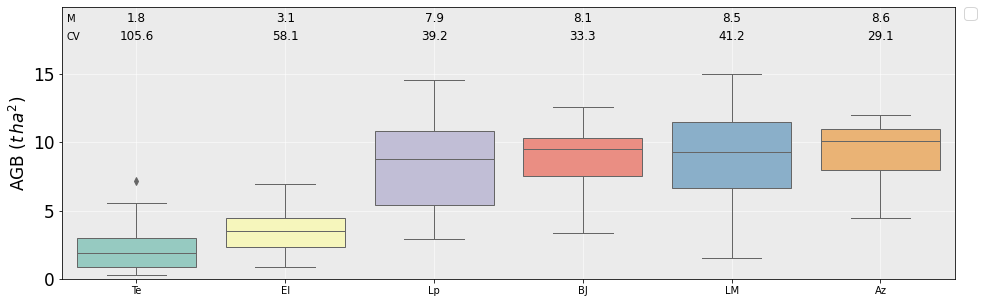

In [8]:
#Calculate statistics
grouped = df.groupby("site")
sorted_mean = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).mean().round(1)
sorted_sd = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).std().round(1)
cv = (sorted_sd/sorted_mean*100).sort_values(ascending=True).round(1)

# Apply order accordingly with mean yield
grouped = df.groupby("site")
sorted_average = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).mean().sort_values(ascending=True)

#Order cv accordingly with mean ascending order
reorderlist = ['Te','El','Lp','BJ','LM','Az']
sorted_cv=cv.reindex(reorderlist)

fig= plt.figure(figsize=(16,5))

# Apply order accordingly with mean yield
grouped = df.groupby("site")
sorted_average = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).mean().sort_values(ascending=True)
#Graph
ax=sns.boxplot(x="site", y="AGB", data=df_bow, palette="Set3", linewidth=1, order=sorted_average.index)
    
# Formatting graph and background
plt.legend(prop=dict(size=16),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('AGB ($t\,ha^{2}$)', fontsize =17)
plt.xlabel('', fontsize =17)

ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=17)
ax.set_ylim([0,19.9])
#plt.savefig('mint.png', dpi=1200)

#Specify mean
def parse(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

df['AGB'] = df['AGB'].apply(parse)
yposlist = df.groupby(['site'])['AGB'].median().tolist()

y2=18.8
xposlist = range(len(yposlist))
stringlist=[sorted_average[0].round(1), sorted_average[1].round(1), sorted_average[2].round(1), sorted_average[3].round(1),
            sorted_average[4].round(1), sorted_average[5].round(1)]

for i in range(len(stringlist)):
    ax.text(xposlist[i],y2,stringlist[i],horizontalalignment='center',size='large',color='k',weight='light')

#Specify cv
def parse(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

df['AGB'] = df['AGB'].apply(parse)
yposlist = df.groupby(['site'])['AGB'].median().tolist()

y2=17.5
xposlist = range(len(yposlist))
stringlist=[sorted_cv[0], sorted_cv[1], sorted_cv[2], sorted_cv[3], sorted_cv[4], sorted_cv[5]]

for i in range(len(stringlist)):
    ax.text(xposlist[i],y2,stringlist[i],horizontalalignment='center',size='large',color='k',weight='light')
    
plt.text(-0.47, 18.8, 'M',fontsize=10,color='k')
plt.text(-0.47, 17.5, 'CV',fontsize=10,color='k')

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\yieldvssite.png', dpi=300,bbox_inches='tight')

In [9]:
df_bow.groupby('soil').count()

,SimulationID,date,year,AGB,Das,rain,radn,tmax,tmin,actualET,...,RowSpacing,SowDensity,EndJuv,PAWC,SimulationName,climate,cultivar,site,env,rain_ETo
soil,,,,,,,,,,,,,,,,,,,,,
BrCh,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
Che8,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
Elli,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
Gui0,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
LLo0,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
LTi1,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
LTi3,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
SGb7,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
Sal0,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22


No handles with labels found to put in legend.


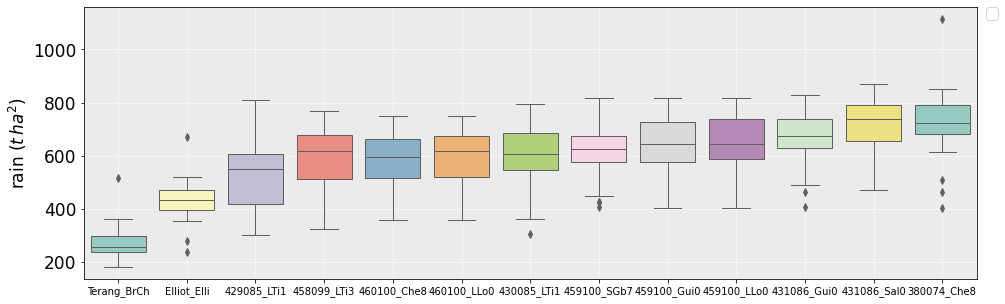

In [10]:
reorderlist = ['380074_Che8', '429085_LTi1', '459100_SGb7', '431086_Gui0',
       '459100_Gui0', 'Elliot_Elli', '430085_LTi1', '458099_LTi3',
       '460100_LLo0', '459100_LLo0', '431086_Sal0', '460100_Che8',
       'Terang_BrCh']

fig= plt.figure(figsize=(16,5))

# Apply order accordingly with mean yield
grouped = df.groupby("env")
sorted_average = pd.DataFrame({col:vals['rain'] for col,vals in grouped}).mean().sort_values(ascending=True)
#Graph
ax=sns.boxplot(x="env", y="rain", data=df_bow, palette="Set3", linewidth=1, order=sorted_average.index)
    
# Formatting graph and background
plt.legend(prop=dict(size=16),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('rain ($t\,ha^{2}$)', fontsize =17)
plt.xlabel('', fontsize =17)

ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=17)
#ax.set_ylim([0,19.9])
#plt.savefig('mint.png', dpi=1200)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\rainvsenv.png', dpi=300,bbox_inches='tight')

In [11]:
#Dataframe with mean and cv
mean = pd.DataFrame([sorted_average]).transpose().round(1)
mean=mean.reset_index()
cv = pd.DataFrame([sorted_cv]).transpose().round(1)
cv=cv.reset_index()
summ=pd.merge(mean, cv, on=['index'])
summ.rename(columns={'index':'climate','0_x':'mean','0_y':'cv'}, inplace=True)
summ

,climate,mean,cv


Text(0.5, 6.79999999999999, 'rain (mm)')

<Figure size 360x360 with 0 Axes>

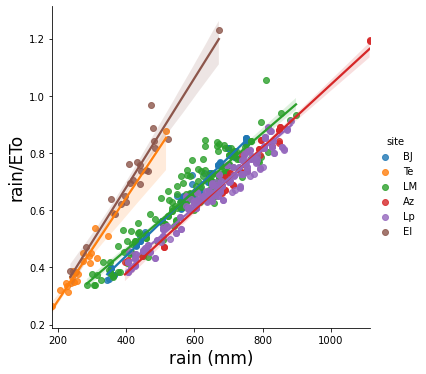

In [12]:
fig = plt.figure(figsize=(5,5))

sns.lmplot(x="rain", y="rain_ETo",hue='site', data=df,ci=95)
# Formatting graph and background
plt.ylabel('rain/ETo', fontsize =17)
plt.xlabel('rain (mm)', fontsize =17)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\rain_ETosite.png', dpi=300,bbox_inches='tight')

Text(0.5, 6.79999999999999, 'actualET (mm)')

<Figure size 360x360 with 0 Axes>

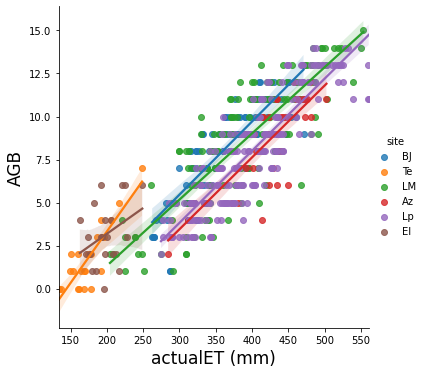

In [13]:
fig = plt.figure(figsize=(5,5))

sns.lmplot(x="actualET", y="AGB",hue='site', data=df,ci=95)
# Formatting graph and background
plt.ylabel('AGB', fontsize =17)
plt.xlabel('actualET (mm)', fontsize =17)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\AGBvsETasite.png', dpi=300,bbox_inches='tight')

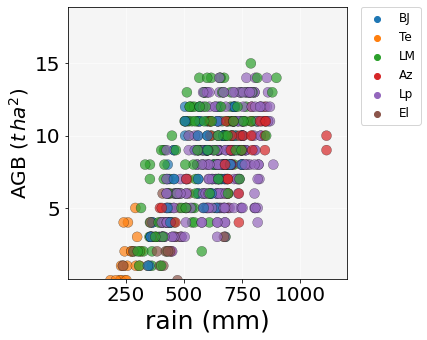

In [14]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
kwargs  =   {'edgecolor':"k"}

fig = plt.figure(figsize=(5,5))

ax=plt.subplot(1, 1, 1)

sns.scatterplot(x="rain", y="AGB",hue="site",s=100, alpha=0.7, data=df,linewidth=0.3,**kwargs,
                markers=filled_markers)

# Formatting graph and background
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('AGB ($t\,ha^{2}$)', fontsize =20)
plt.xlabel('rain (mm)', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(250))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1,1199])
ax.set_ylim([0.1,18.9])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\agbVSrainsite.png', dpi=300,bbox_inches='tight')

In [15]:
#Calculate statistics
summ = df_bow.groupby(['env','site'], as_index=False)['AGB','radn','PAWC','rain','tmax','tmin','actualET'].mean().round(decimals=1)

<ipython-input-15-207eba10b9a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summ = df_bow.groupby(['env','site'], as_index=False)['AGB','radn','PAWC','rain','tmax','tmin','actualET'].mean().round(decimals=1)


In [ ]:
summ.describe()

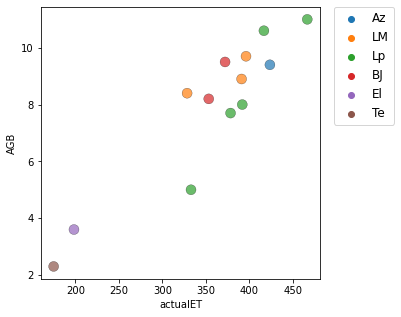

In [16]:
fig = plt.figure(figsize=(5,5))

ax=plt.subplot(1, 1, 1)

sns.scatterplot(x="actualET", y="AGB",hue='site',s=100, alpha=0.7, data=summ,linewidth=0.3,**kwargs)
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\agbVSETasite.png', dpi=300,bbox_inches='tight')

In [ ]:
# Original author: Thomas Haslwanter

import numpy as np
import matplotlib.pyplot as plt
import pandas

# For 3d plots. This import is necessary to have 3D plotting below
from mpl_toolkits.mplot3d import Axes3D

# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

In [ ]:
df_bow.shape

In [ ]:
list(df_bow.columns)

In [17]:
model = ols("AGB ~ actualET + rain", summ).fit()
# Print the summary
print(model.summary())

print("\nRetrieving manually the parameter estimates:")
print(model._results.params)
# should be array([-4.99754526,  3.00250049, -0.50514907])

# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)

plt.show()

NameError: name 'ols' is not defined

NameError: name 'PAWC' is not defined

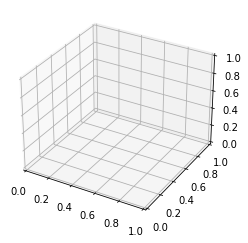

In [18]:
# Plot the data
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(PAWC.summ, AGB.summ, radn.summ, cmap=plt.cm.coolwarm,
                       rstride=1, cstride=1)
ax.view_init(20, -120)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

<AxesSubplot:ylabel='Frequency'>

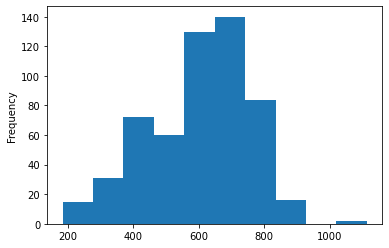

In [24]:
df.rain.plot.hist()

<ipython-input-32-bdc59b2a7598>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
<ipython-input-32-bdc59b2a7598>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


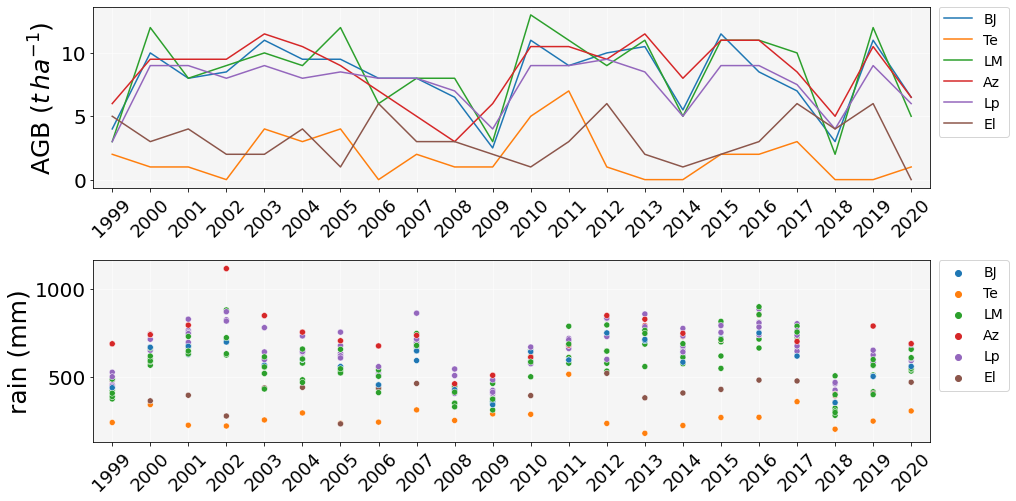

In [32]:
fig = plt.figure(figsize=(15,8))
ax=plt.subplot(2, 1, 1)
sns.lineplot(x="year", y="AGB", hue='site', estimator=np.median, data=df,ci=None, err_style="band")

# Formatting graph and background
plt.legend(prop=dict(size=14),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('AGB ($t\,ha^{-1}$)', fontsize =25)
plt.xlabel('', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([1998.5,2020.5])

ax=plt.subplot(2,1,2)

sns.scatterplot(x="year", y="rain", hue='site', data=df)
# Formatting graph and background
plt.legend(prop=dict(size=14),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('rain (mm)', fontsize =25)
plt.xlabel('', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([1998.5,2020.5])

####################################################################
plt.subplots_adjust(wspace=0.2, hspace=0.4)

#ax.set_title('a',fontsize= 40,weight='bold') 
#ax.title.set_position([1.03,-0.02])

#plt.savefig(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\AGBvsyearenv.png', dpi=300,bbox_inches='tight')